#### Librerias


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pypfopt import EfficientFrontier, expected_returns
from pypfopt import risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import quantstats as qs
from matplotlib.ticker import FuncFormatter

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Funciones


###### _Log y Pct rends_


In [148]:
# funcion rendimientos log
def rlog(data):
    return np.log(data / data.shift(1)).dropna()

###### _Portafolios y metricas_


In [149]:
# Función para calcular el portafolio con máximo Sharpe (devuelve valores ponderados)
def calculate_max_sharpe(prices, risk_free=0.05, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_sharpe(risk_free_rate=risk_free)
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


In [150]:

# Función para calcular el portafolio de mínima volatilidad
def calculate_min_volatility(prices, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


In [151]:

# Función para calcular el portafolio de máximo rendimiento esperado
def calculate_max_return(prices, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.max_quadratic_utility()
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


In [168]:
# Funcion para calcular un portafolio de pesos iguales con pyportfolioopt
def calculate_equal_weights(prices, save_weights=False):
    prices = prices.dropna()
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.efficient_return(target_return=0.2, market_neutral=True)
    weights = ef.clean_weights()
    if save_weights:
        return weights
    return prices.mul(weights, axis=1).sum(axis=1)

In [152]:

# Función para calcular un portafolio con límite de riesgo fijo
def calculate_risk_limit(prices, risk_limit=0.02, save_weights=False):
    vol = prices.pct_change().rolling(window=30).std() * np.sqrt(252)
    weights = vol.mean(axis=1).apply(lambda x: 0.6 if x < risk_limit else 0.4)
    if save_weights:
        return
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


In [176]:
calculate_risk_limit(major_w_cripto, risk_limit=0.60, save_weights=False)


Date
2020-04-10 00:00:00+00:00    0.0
2020-04-13 00:00:00+00:00    0.0
2020-04-14 00:00:00+00:00    0.0
2020-04-15 00:00:00+00:00    0.0
2020-04-16 00:00:00+00:00    0.0
                            ... 
2024-08-15 00:00:00+00:00    0.0
2024-08-16 00:00:00+00:00    0.0
2024-08-19 00:00:00+00:00    0.0
2024-08-20 00:00:00+00:00    0.0
2024-08-21 00:00:00+00:00    0.0
Length: 1137, dtype: float64

In [153]:

# Funcion para calculrar portafolio con un riesgo fijo usando pyportfolioopt
def calculate_risk_limit2(prices, risk_limit=0.02, save_weights=False):
    prices = prices.dropna()    
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()
    if save_weights:
        return weights
    # Multiplica precios históricos por los pesos para obtener valores ponderados
    return prices.mul(weights, axis=1).sum(axis=1)


In [173]:

# Función para agregar activos y portafolios a un solo DataFrame
def generate_portfolio_df(data, include_sharpe=True, include_min_vol=True, include_max_return=True, include_equal_weight=True, include_risk_limit=True, risk_free=0.05, risk_limit=0.02, include_assets=False, save_weights=False):
    # Crear una copia del DataFrame original
    portfolio_df = data.copy()

    # Calcular y añadir las estrategias seleccionadas al DataFrame
    if include_sharpe:
        portfolio_df['Max_Sharpe'] = calculate_max_sharpe(data, risk_free=risk_free, save_weights=save_weights)
    if include_min_vol:
        portfolio_df['Min_Volatility'] = calculate_min_volatility(data, save_weights=save_weights)
    if include_max_return:
        portfolio_df['Max_Return'] = calculate_max_return(data, save_weights=save_weights)
    if include_equal_weight:
        portfolio_df['Equal_Weight'] = calculate_equal_weights(data, save_weights=save_weights)
    if include_risk_limit:
        portfolio_df['Risk_Limit'] = calculate_risk_limit(data, risk_limit=risk_limit, save_weights=save_weights)
        portfolio_df['Risk_Limit2'] = calculate_risk_limit2(data, risk_limit=risk_limit, save_weights=save_weights)
# para hacer que solo regrese los portafolios y no los activos se usa el siguiente codigo
#     # Eliminar las columnas de activos
    if not include_assets:
        portfolio_df = portfolio_df.drop(data.columns, axis=1)
    return portfolio_df

###### Add cripto to portafolio

In [155]:
# Funcion para agregar criptos a portafolios tradicionales
def add_cripto(tradicionales, cripto, cry_list):
    """
    Combina un DataFrame de activos tradicionales con criptomonedas seleccionadas,
    alineando los datos por fecha.
    
    Parámetros:
    tradicionales (pd.DataFrame): DataFrame con los datos de activos tradicionales, con fechas como índice.
    criptomonedas (pd.DataFrame): DataFrame con los datos de todas las criptomonedas, con fechas como índice.
    cry_list (list): Lista de nombres de criptomonedas a incluir.
    
    Retorna:
    pd.DataFrame: DataFrame combinado con activos tradicionales y criptomonedas seleccionadas, alineados por fecha.
    """
    # Asegurarse de que ambos DataFrames tengan índices de tipo datetime
    tradicionales.index = pd.to_datetime(tradicionales.index)
    cripto.index = pd.to_datetime(cripto.index)
    
    # añadir un try para evitar errores
    try:
        # Verificar que las criptomonedas seleccionadas existan en el DataFrame
        cry_list = [crypto for crypto in cry_list if crypto in cripto.columns]
    except:
        print('Error: cripto no es un DataFrame')
    # Verificar que las criptomonedas seleccionadas existan en el DataFrame
    
    # Seleccionar solo las criptomonedas de la lista
    criptos_seleccionadas = cripto[cry_list]
    
    # Combinar los DataFrames, alineando por fecha
    combinado = pd.concat([tradicionales, criptos_seleccionadas], axis=1, join='inner')
    
    return combinado

###### Frontera Eficiente

In [156]:
# Función para generar combinaciones aleatorias de portafolios
def weight_portfolios(activos, iteraciones=10000, min_weight=0.01):
    max_weight = 1 - (len(activos) * min_weight)
    portfolios = []
    for _ in range(iteraciones):
        weights = np.random.dirichlet(np.ones(len(activos)), size=1)[0]
        weights = np.clip(weights, min_weight, max_weight)
        portfolios.append(weights)
    portfolios = pd.DataFrame(portfolios, columns=activos)
    return portfolios

# Función para calcular y obtener métricas de portafolios específicos
def calcular_portafolios_especificos(returns, risk_free=0.05, risk_limit=0.20):
    mu = expected_returns.mean_historical_return(returns)
    S = risk_models.sample_cov(returns)
    ef = EfficientFrontier(mu, S)

    # Portafolio de máximo Sharpe
    ef.max_sharpe(risk_free_rate=risk_free)
    weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)

    # Portafolio de mínima volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    ef_min_vol.min_volatility()
    weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance()

    # Portafolio de pesos iguales
    n_assets = len(mu)
    weights_equal = np.array([1/n_assets] * n_assets)
    ret_equal = np.dot(weights_equal, mu)
    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))
    sharpe_equal = (ret_equal - risk_free) / vol_equal
    performance_equal = (ret_equal, vol_equal, sharpe_equal)
    
    # Portafolio de máxima utilidad cuadrática
    ef_max_utility = EfficientFrontier(mu, S)
    ef_max_utility.max_quadratic_utility()
    weights_max_utility = ef_max_utility.clean_weights()
    performance_max_utility = ef_max_utility.portfolio_performance()

    # Portafolio de riesgo fijo
    ef_risk_limit = EfficientFrontier(mu, S)
    ef_risk_limit.efficient_risk(risk_limit)
    weights_risk_limit = ef_risk_limit.clean_weights()
    performance_risk_limit = ef_risk_limit.portfolio_performance()
    
    # Métricas de los activos individuales
    performance_activos = []
    for i, asset in enumerate(returns.columns):
        weights_asset = np.zeros(n_assets)
        weights_asset[i] = 1
        ret_asset = np.dot(weights_asset, mu)
        vol_asset = np.sqrt(np.dot(weights_asset.T, np.dot(S, weights_asset)))
        sharpe_asset = (ret_asset - risk_free) / vol_asset
        performance_activos.append((asset, ret_asset, vol_asset, sharpe_asset))

    return {
        "sharpe": {"weights": weights_sharpe, "performance": performance_sharpe},
        "min_vol": {"weights": weights_min_vol, "performance": performance_min_vol},
        "equal": {"weights": weights_equal, "performance": performance_equal},
        "max_utility": {"weights": weights_max_utility, "performance": performance_max_utility},
        "risk_limit": {"weights": weights_risk_limit, "performance": performance_risk_limit},
        "activos": performance_activos
    }

    # Función para calcular las métricas de los portafolios generados aleatoriamente
def calcular_metricas_aleatorias(portfolios, mu, S, risk_free=0.05):
    expected_returns_all = portfolios.dot(mu)
    portfolio_volatility = np.sqrt(np.diag(portfolios.dot(S).dot(portfolios.T)))
    sharpe_ratios = (expected_returns_all - risk_free) / portfolio_volatility
    return expected_returns_all, portfolio_volatility, sharpe_ratios


# Función para graficar la frontera eficiente y los portafolios específicos
def graficar_frontera_eficiente(data, iteraciones=10000, risk_free=0.05, min_weight=0.01, risk_limit=0.20):
    data = data.dropna()
    activos = data.columns.tolist()
    portfolios = weight_portfolios(activos, iteraciones, min_weight=min_weight)

    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    expected_returns_all, portfolio_volatility, sharpe_ratios = calcular_metricas_aleatorias(portfolios, mu, S, risk_free)

    # Calcular portafolios específicos
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit)
    
    # Preparar datos para la gráfica
    rendimiento_sharpe = portafolios_especificos["sharpe"]["performance"][0]
    riesgo_sharpe = portafolios_especificos["sharpe"]["performance"][1]

    rendimiento_min_var = portafolios_especificos["min_vol"]["performance"][0]
    riesgo_min_var = portafolios_especificos["min_vol"]["performance"][1]
    
    rendimiento_max_utility = portafolios_especificos["max_utility"]["performance"][0]
    riesgo_max_utility = portafolios_especificos["max_utility"]["performance"][1]

    rendimiento_igual = portafolios_especificos["equal"]["performance"][0]
    riesgo_igual = portafolios_especificos["equal"]["performance"][1]

    rendimiento_risk_limit = portafolios_especificos["risk_limit"]["performance"][0]
    riesgo_risk_limit = portafolios_especificos["risk_limit"]["performance"][1]

    # Graficar
    plt.figure(figsize=(12, 8))
    plt.scatter(portfolio_volatility, expected_returns_all*100, c=sharpe_ratios, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Ratio de Sharpe', pad=0.1) 

    # Mejorar el estilo de la gráfica
    plt.xlabel('Volatilidad (Riesgo del Portafolio)', fontsize=12, fontweight='bold')
    plt.ylabel('Rendimiento Esperado del Portafolio % (anual)', fontsize=12, fontweight='bold')
    plt.title('Gráfica de Dispersión: Rendimiento vs. Volatilidad', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Añadir el punto del portafolio de mínima varianza en rojo
    plt.scatter(riesgo_min_var, rendimiento_min_var*100, color='#FF3030', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Mínima Varianza')

    # Añadir el punto del portafolio de pesos iguales en morado
    plt.scatter(riesgo_igual, rendimiento_igual*100, color='#8B008B', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio Equal Weight')

    # Añadir el punto del portafolio de máximo Sharpe en azul
    plt.scatter(riesgo_sharpe, rendimiento_sharpe*100, color='#00FFFF', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máximo Sharpe')
    
    # Añadir el punto del portafolio de máxima utilidad cuadrática en verde
    plt.scatter(riesgo_max_utility, rendimiento_max_utility*100, color='#76EE00', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máxima Utilidad Cuadrática')

    # Añadir el punto del portafolio de riesgo fijo en naranja
    plt.scatter(riesgo_risk_limit, rendimiento_risk_limit*100, color='#FFD700', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Riesgo Fijo')

    # Añadir los puntos de los activos individuales con etiquetas en la gráfica
    for (asset, ret_asset, vol_asset, sharpe_asset) in portafolios_especificos["activos"]:
        plt.scatter(vol_asset, ret_asset*100, marker='o', s=35, edgecolors='black', facecolors='none')
        plt.text(vol_asset, (ret_asset*100)-3, asset, fontsize=8, fontweight='bold', ha='center', color='#0A0A0A')

    plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.01, 0.99)) 
    plt.text(0.5, 0.96, f'Tasa libre de riesgo: {risk_free*100:.2f}%', transform=plt.gca().transAxes, fontsize=10, color='#363636')
    plt.show()




Grafica de pie con pesos de cada activo en cada portafolio

In [157]:
def plot_portfolio_pies(data, risk_free=0.05, risk_limit=0.20):
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free, risk_limit)
    
    portafolios = ["sharpe", "min_vol", "equal", "max_utility", "risk_limit"]
    n_portfolios = len(portafolios)
    
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=len(data.columns))
    
    # Crear un mapa de colores consistente para los activos
    color_map = dict(zip(data.columns, sns.color_palette("husl", n_colors=len(data.columns))))
    
    fig, axs = plt.subplots(1, n_portfolios, figsize=(20, 8))
    fig.suptitle('Distribución de Activos en Diferentes Portafolios', fontsize=16, fontweight='bold')

    for i, portfolio in enumerate(portafolios):
        weights = portafolios_especificos[portfolio]['weights']
        
        if isinstance(weights, dict):
            assets = list(weights.keys())
            values = list(weights.values())
        else:
            assets = data.columns
            values = weights
        
        # Ordenar los valores y activos de mayor a menor
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = np.array(values)[sorted_indices]
        sorted_assets = np.array(assets)[sorted_indices]
        
        # Crear el gráfico de pastel
        colors = [color_map[asset] for asset in sorted_assets]
        wedges, _, autotexts = axs[i].pie(sorted_values, autopct='%1.1f%%', 
                                          startangle=90, colors=colors, 
                                          wedgeprops=dict(width=0.6, edgecolor='white'))
        
        # Ajustar el texto dentro de los wedges
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        axs[i].set_title(f'Portafolio: {portfolio.capitalize()}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Añadir una única leyenda debajo del título principal
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[asset], edgecolor='none') for asset in data.columns]
    fig.legend(legend_elements, data.columns, loc='upper center', bbox_to_anchor=(0.5, 0.92),
               ncol=len(data.columns), fontsize=10, title='Activos', title_fontsize=12)
    
    plt.subplots_adjust(top=0.8, bottom=0.1)
    plt.show()

###### _Drawdown y Rendimientos acumulados_


In [239]:
def plot_performance_and_drawdown(data, benchmark='BTC'):
    # Calcular rendimientos diarios y acumulados
    returns = data.pct_change()
    cumulative_returns = (1 + returns).cumprod() - 1

    # Calcular drawdowns
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", n_colors=len(data.columns))
    color_map = dict(zip(data.columns, colors))

    # Crear la figura y los subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Rendimiento y Drawdown de Activos', fontsize=16, fontweight='bold')

    # Subplot 1: Rendimiento acumulado (escala logarítmica)
    for col in cumulative_returns.columns:
        ax1.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col], linewidth=2)
    
    ax1.set_ylabel('Rendimiento Acumulado', fontsize=12)
    ax1.set_title('Rendimiento Acumulado (escala logarítmica)', fontsize=14, fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Función para formatear el eje Y en porcentajes
    def percent_formatter(y, pos):
        return f'{(y-1)*100:.0f}%' #if y < 2 else f'{y-1:.0f}x'

    ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
    
    # Crear escala personalizada para el eje Y
    yticks = [1, 2, 11, 26, 51, 101, 151, 201]
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([percent_formatter(y, 0) for y in yticks])

    # Ajustar los límites del eje Y
    ax1.set_ylim(bottom=max(0.1, 1 + cumulative_returns.min().min()), top=300)

    # Añadir líneas horizontales en el subplot de rendimiento
    for y in yticks:
        ax1.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Subplot 2: Drawdown
    for col in drawdown.columns:
        ax2.fill_between(drawdown.index, drawdown[col], 0, label=col, color=color_map[col], alpha=0.3, linewidth=4)
        # Hacerlo con lineas en vez de 
        #ax2.plot(drawdown.index, drawdown[col], label=col, color=color_map[col], linewidth=2)    
    ax2.set_ylabel('Drawdown', fontsize=12)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylim(-1, 0)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Añadir línea de drawdown medio del benchmark
    mean_drawdown = drawdown[benchmark].mean()
    ax2.axhline(y=mean_drawdown, color='red', linestyle='--', linewidth=2)
    ax2.text(drawdown.index[-1], mean_drawdown, f'Drawdown medio de {benchmark}: {mean_drawdown:.2%}', 
             verticalalignment='bottom', horizontalalignment='right', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [159]:
def plot_performance_and_drawdown2(data, benchmark='BTC'):
    # Calcular rendimientos diarios y acumulados
    returns = data.pct_change()
    cumulative_returns = (1 + returns).cumprod() - 1

    # Calcular drawdowns
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak

    # Configurar el estilo
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", n_colors=len(data.columns))
    color_map = dict(zip(data.columns, colors))

    # Crear la figura y los subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Rendimiento y Drawdown de Activos', fontsize=16, fontweight='bold')

    # Subplot 1: Rendimiento acumulado
    for col in cumulative_returns.columns:
        ax1.semilogy(cumulative_returns.index, 1 + cumulative_returns[col], label=col, color=color_map[col])
    
    ax1.set_ylabel('Rendimiento Acumulado (%)', fontsize=12)
    ax1.set_title('Rendimiento Acumulado', fontsize=14, fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y-1)))
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Añadir líneas horizontales en el subplot de rendimiento
    yticks = [1, 2, 5, 10, 20, 50, 100, 200]
    ax1.set_yticks([y for y in yticks])
    ax1.set_yticklabels([f'{(y-1):.0%}' for y in yticks])
    for y in yticks:
        ax1.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Subplot 2: Drawdown
    for col in drawdown.columns:
        ax2.fill_between(drawdown.index, drawdown[col], 0, label=col, color=color_map[col], alpha=0.3)
    
    ax2.set_ylabel('Drawdown', fontsize=12)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylim(-1, 0)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Añadir línea de drawdown medio del benchmark
    mean_drawdown = drawdown[benchmark].mean()
    ax2.axhline(y=mean_drawdown, color='red', linestyle='--', linewidth=2)
    ax2.text(drawdown.index[-1], mean_drawdown, f'Drawdown medio de {benchmark}: {mean_drawdown:.2%}', 
             verticalalignment='bottom', horizontalalignment='right', color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()


###### Matriz de correlacion

In [160]:
# Funcion para graficar matriz de correlacion de activos
def graficar_matriz_correlacion(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.pct_change().corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Matriz de Correlación de Activos', fontsize=14, fontweight='bold')
    plt.show()


###### _Meticas clave_


In [161]:
# Obtener key metrics de los portafolios con quantstats
def key_metrics(data, risk_free=0.05):
    rendimientos = data.pct_change().dropna()
    qs.reports.html(rendimientos, output='report.html', rf=risk_free)
    return qs.reports.metrics(rendimientos, mode='full', rf=risk_free)

#### Data


In [30]:
# Fecha de inicio
start = '2017-01-01'

In [88]:
# Obtener datos de criptomonedas con Yahoo Finance
tk_cry = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'TRX-USD', 'BNB-USD']
tk_cry.sort() #? Se deben ordenar alfabeticamente para que coincidan con los nombres de las columnas
cripto = yf.download(tk_cry, start=start)['Adj Close']
cripto.columns = [tk.split('-')[0] for tk in tk_cry]
cripto.dropna(inplace=True)
cripto.head()

[*********************100%***********************]  5 of 5 completed


,BNB,BTC,ETH,SOL,TRX
Date,,,,,
2020-04-10 00:00:00+00:00,13.737724,6865.493164,158.412445,0.951054,0.012462
2020-04-11 00:00:00+00:00,13.804288,6859.083008,158.216019,0.776819,0.012483
2020-04-12 00:00:00+00:00,14.375111,6971.091797,161.142426,0.882507,0.012902
2020-04-13 00:00:00+00:00,15.034427,6845.037598,156.279556,0.777832,0.012585
2020-04-14 00:00:00+00:00,15.525076,6842.427734,157.596390,0.661925,0.012413


<Axes: xlabel='Date'>

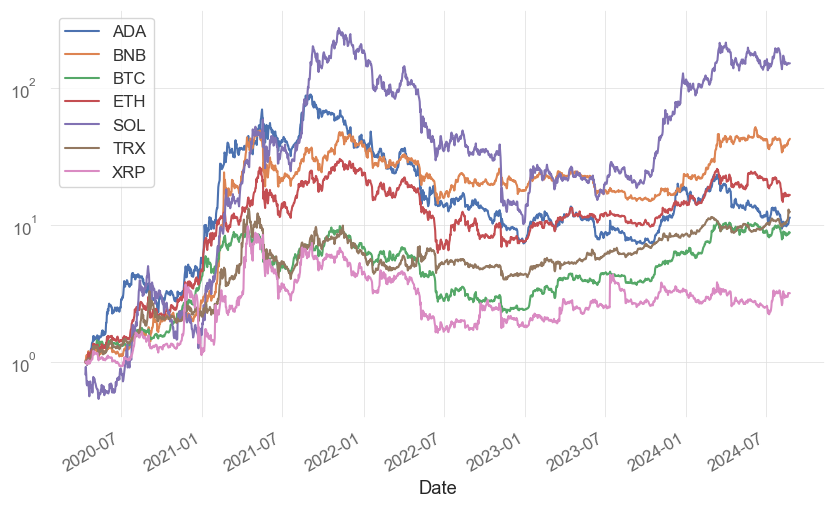

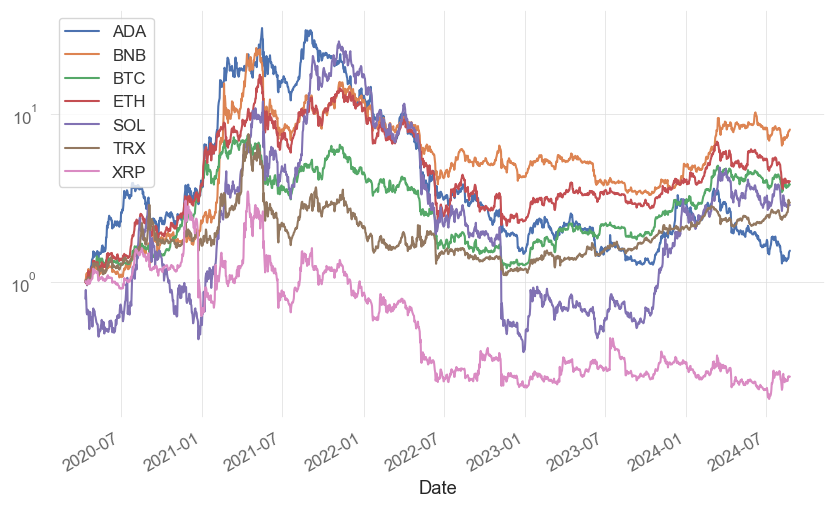

In [76]:
# Grafica con rendimientos acumulados con escala y logaritmica de niveles
(1 + cripto.pct_change().dropna()).cumprod().plot(figsize=(10, 6), logy=True)

In [17]:
# Obtener datos de ETF mercados emergentes
tk_emerg_etf = ['EEM', 'VWO']
emerg_etf = yf.download(tk_emerg_etf, start=start)['Adj Close']
emerg_etf.columns = ['EEM', 'VWO']
emerg_etf.head()

[*********************100%***********************]  2 of 2 completed


,EEM,VWO
Date,,
2015-01-02 00:00:00+00:00,31.612555,30.274822
2015-01-05 00:00:00+00:00,31.049938,29.792683
2015-01-06 00:00:00+00:00,30.919468,29.647284
2015-01-07 00:00:00+00:00,31.588099,30.328384
2015-01-08 00:00:00+00:00,32.126244,30.841131


In [18]:
# Obtener datos de principales indices del mundo
tk_major_ind = ['^GSPC', '^IXIC', '^GDAXI', '^FTSE', '^N225']
major_ind = yf.download(tk_major_ind, start=start)['Adj Close']
major_ind.columns = ['SP500', 'NASDAQ', 'DAX', 'FTSE', 'NIKKEI']
major_ind.head()

[*********************100%***********************]  5 of 5 completed


,SP500,NASDAQ,DAX,FTSE,NIKKEI
Date,,,,,
2015-01-02 00:00:00+00:00,6547.799805,9764.730469,2058.199951,4726.810059,NaN
2015-01-05 00:00:00+00:00,6417.200195,9473.160156,2020.579956,4652.569824,17408.710938
2015-01-06 00:00:00+00:00,6366.500000,9469.660156,2002.609985,4592.740234,16883.189453
2015-01-07 00:00:00+00:00,6419.799805,9518.179688,2025.900024,4650.470215,16885.330078
2015-01-08 00:00:00+00:00,6570.000000,9837.610352,2062.139893,4736.189941,17167.099609


In [19]:
# Datos de indices principales de Mexico, brasil, china, india, rusia, turquia, colombia, argentina, taiwan, corea del sur, sudafrica, indonesia, tailandia, malasia, filipinas, polonia, hungria, chile, peru, egipto
tk_emerging_markets = ['^MXX', '^BVSP', '000001.SS', '^BSESN', '^N225', '^ATG', '^MERV', '^TWII', '^KS11', '^JN0U.FGI', '^FTSEJSE', '^JKSE', '^SET.BK', '^KLSE', '^PSEI', '^WIG', '^BUX', '^IPSA', '^SPBLPGPT', '^EGX30']
emerging_markets = yf.download(tk_emerging_markets, start=start)['Adj Close']
emerging_markets.columns = ['MEX', 'BRA', 'CHN', 'IND', 'RUS', 'TUR', 'COL', 'ARG', 'TWN', 'KOR', 'ZAF', 'IDN', 'THA', 'MYS', 'PHL', 'POL', 'HUN', 'CHL', 'PER', 'EGY']
emerging_markets.head()

[*********************100%***********************]  20 of 20 completed

4 Failed downloads:
['^JN0U.FGI', '^PSEI', '^FTSEJSE', '^EGX30']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


,MEX,BRA,CHN,IND,RUS,TUR,COL,ARG,TWN,KOR,ZAF,IDN,THA,MYS,PHL,POL,HUN,CHL,PER,EGY
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,NaN,811.489990,27887.900391,NaN,48512.0,NaN,NaN,3851.229980,5242.564941,NaN,1752.770020,1926.439941,8667.0,42115.468750,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,3350.519043,759.700012,27842.320312,16414.800781,47517.0,NaN,NaN,3797.989990,5219.791992,NaN,1736.619995,1915.750000,8124.0,41099.371094,17408.710938,NaN,1483.250000,14540.860352,9274.068359,NaN
2015-01-06 00:00:00+00:00,3351.446045,758.580017,26987.460938,16173.610352,48001.0,NaN,NaN,3776.639893,5168.858398,NaN,1716.579956,1882.449951,8058.0,41329.410156,16883.189453,NaN,1477.579956,14540.929688,9048.298828,NaN
2015-01-07 00:00:00+00:00,3373.954102,732.330017,26908.820312,16191.370117,49463.0,NaN,NaN,3776.649902,5206.915039,NaN,1709.180054,1883.829956,8246.0,41813.929688,16885.330078,NaN,1500.750000,14489.660156,9080.047852,NaN
2015-01-08 00:00:00+00:00,3293.456055,717.000000,27274.710938,16441.679688,49943.0,NaN,NaN,3785.570068,5211.625000,NaN,1728.060059,1904.650024,8395.0,42402.308594,17167.099609,NaN,1521.619995,14432.610352,9237.988281,NaN


In [20]:
# Datos de materias, oro, petroleo
tk_commodities = ['GC=F', 'CL=F']
commodities = yf.download(tk_commodities, start=start)['Adj Close']
commodities.columns = ['Gold', 'Oil']
commodities.head()

[*********************100%***********************]  2 of 2 completed


,Gold,Oil
Date,,
2015-01-02 00:00:00+00:00,52.689999,1186.000000
2015-01-05 00:00:00+00:00,50.040001,1203.900024
2015-01-06 00:00:00+00:00,47.930000,1219.300049
2015-01-07 00:00:00+00:00,48.650002,1210.599976
2015-01-08 00:00:00+00:00,48.790001,1208.400024


In [21]:
# Datos de divisas
tk_fx = ['EURUSD=X', 'JPY=X', 'GBPUSD=X']
fx = yf.download(tk_fx, start=start)['Adj Close']
fx.columns = ['EURUSD', 'JPY', 'GBPUSD']
fx.head()

[*********************100%***********************]  3 of 3 completed


,EURUSD,JPY,GBPUSD
Date,,,
2015-01-01 00:00:00+00:00,1.209863,1.558094,119.672997
2015-01-02 00:00:00+00:00,1.208941,1.557972,119.870003
2015-01-05 00:00:00+00:00,1.194643,1.528491,120.433998
2015-01-06 00:00:00+00:00,1.193902,1.525832,119.425003
2015-01-07 00:00:00+00:00,1.187536,1.513798,118.672997


#### Analisis


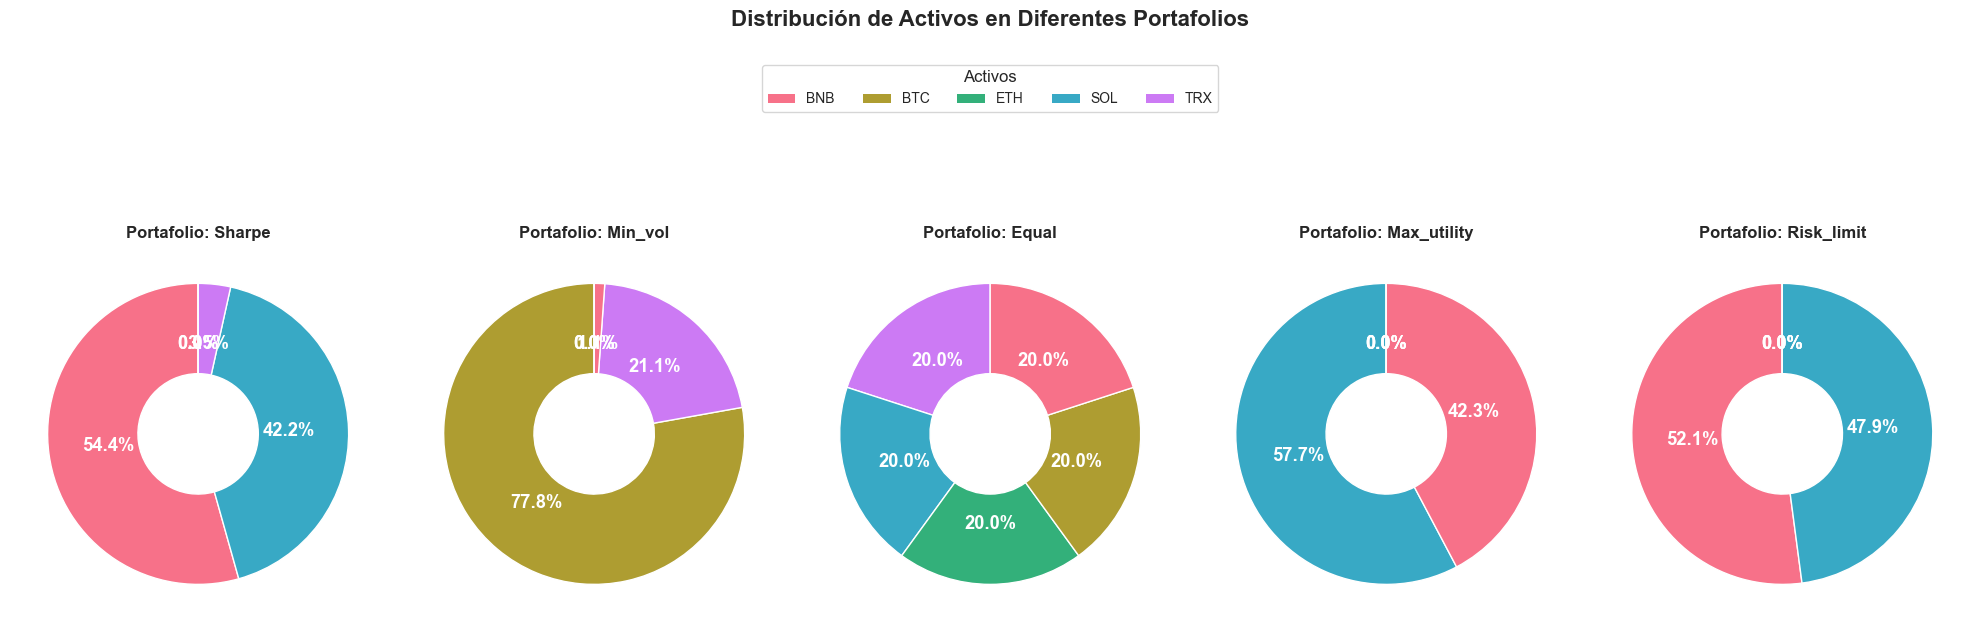

In [98]:
plot_portfolio_pies(cripto, risk_free=0.05, risk_limit=0.80)

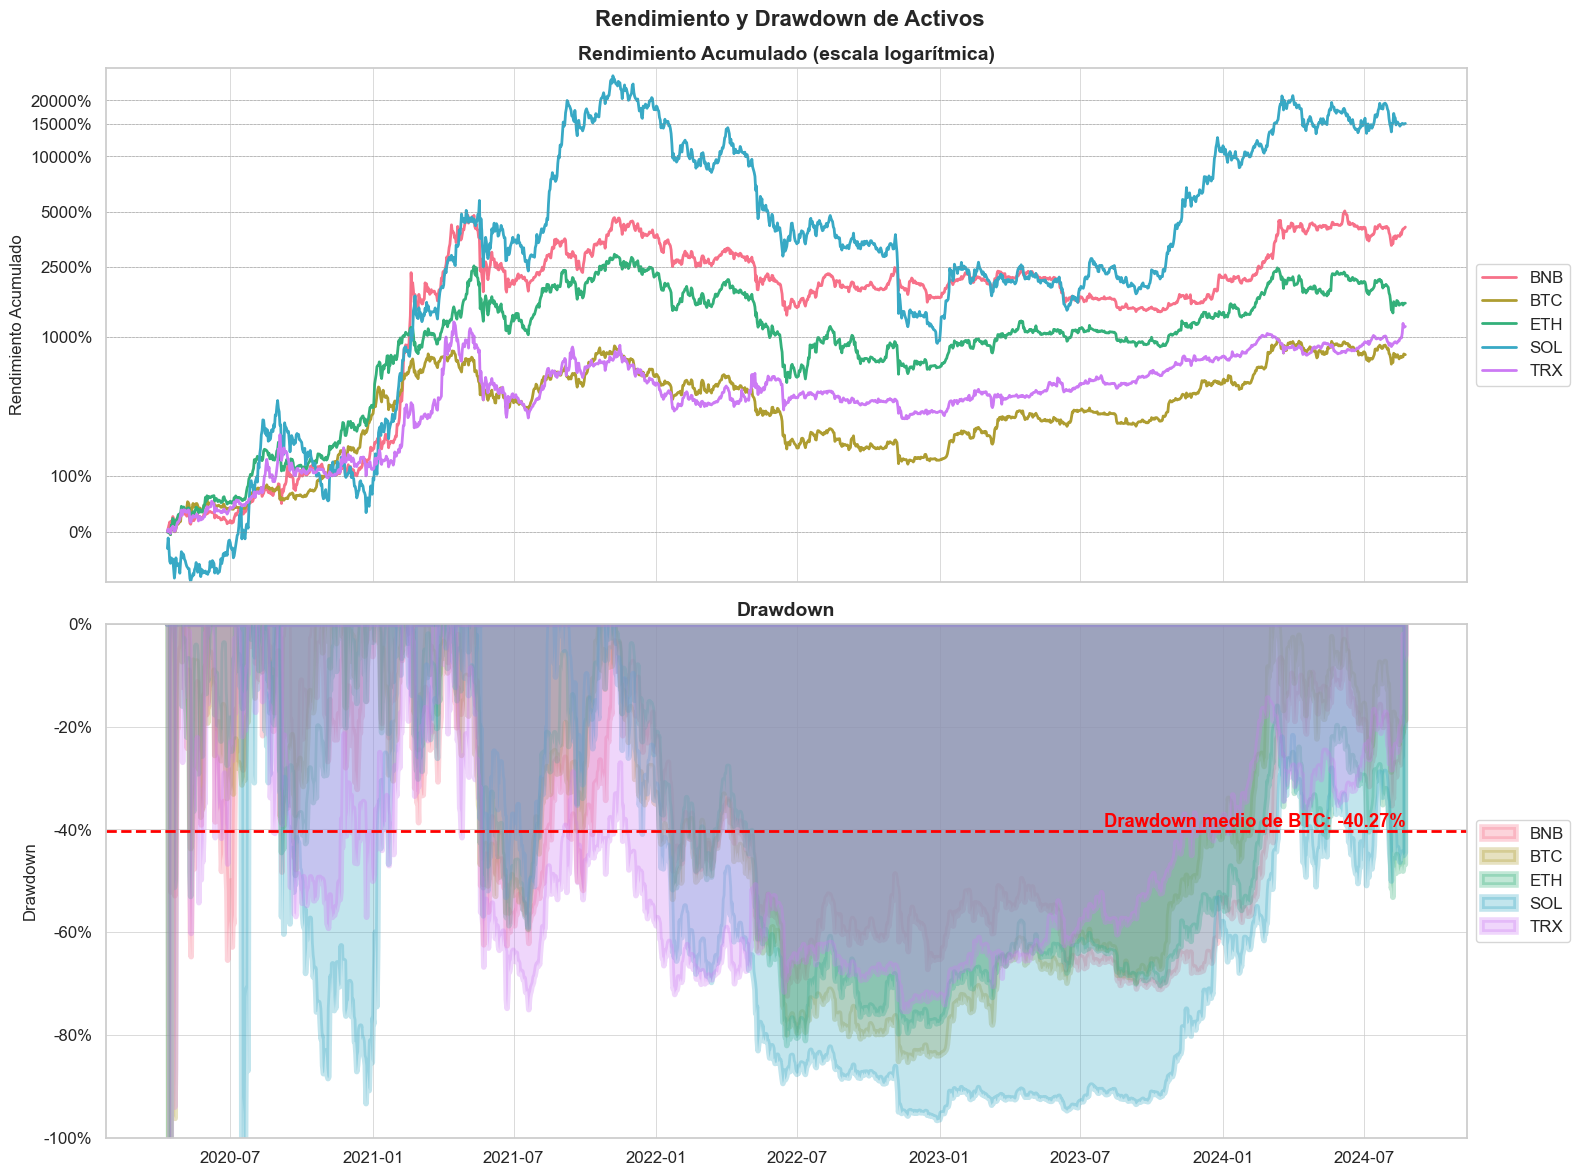

In [240]:
plot_performance_and_drawdown(cripto, benchmark='BTC')

In [115]:
major_w_cripto = add_cripto(major_ind, cripto, ['BTC', 'ETH', 'SOL'])
major_w_cripto.head()

,SP500,NASDAQ,DAX,FTSE,NIKKEI,BTC,ETH,SOL
Date,,,,,,,,
2020-04-10 00:00:00+00:00,NaN,NaN,NaN,NaN,19498.500000,6865.493164,158.412445,0.951054
2020-04-13 00:00:00+00:00,NaN,NaN,2761.629883,8192.419922,19043.400391,6845.037598,156.279556,0.777832
2020-04-14 00:00:00+00:00,5791.299805,10696.559570,2846.060059,8515.740234,19638.810547,6842.427734,157.596390,0.661925
2020-04-15 00:00:00+00:00,5597.700195,10279.759766,2783.360107,8393.179688,19550.089844,6642.109863,153.286896,0.646651
2020-04-16 00:00:00+00:00,5628.399902,10301.540039,2799.550049,8532.360352,19290.199219,7116.804199,172.157379,0.690816


In [174]:
major_w_cripto_port = generate_portfolio_df(major_w_cripto, 
                      include_sharpe=True, 
                      include_min_vol=True, 
                      include_max_return=True,
                      include_equal_weight=True, 
                      include_risk_limit=True, 
                      risk_free=0.05, 
                      risk_limit=0.80,
                      include_assets=False,
                      save_weights=False)
major_w_cripto_port=major_w_cripto_port.dropna()
major_w_cripto_port.head()

,Max_Sharpe,Min_Volatility,Max_Return,Equal_Weight,Risk_Limit,Risk_Limit2
Date,,,,,,
2020-04-14 00:00:00+00:00,10226.630030,8053.174498,0.661925,650.278051,0.0,8870.488498
2020-04-15 00:00:00+00:00,10167.827050,7921.112178,0.646651,652.139500,0.0,8828.836241
2020-04-16 00:00:00+00:00,10052.160505,7882.226293,0.690816,617.744167,0.0,8716.722601
2020-04-17 00:00:00+00:00,10362.014757,8117.497006,0.660728,654.964515,0.0,8988.739096
2020-04-20 00:00:00+00:00,10237.400066,8063.787634,0.538812,635.997221,0.0,8884.379863


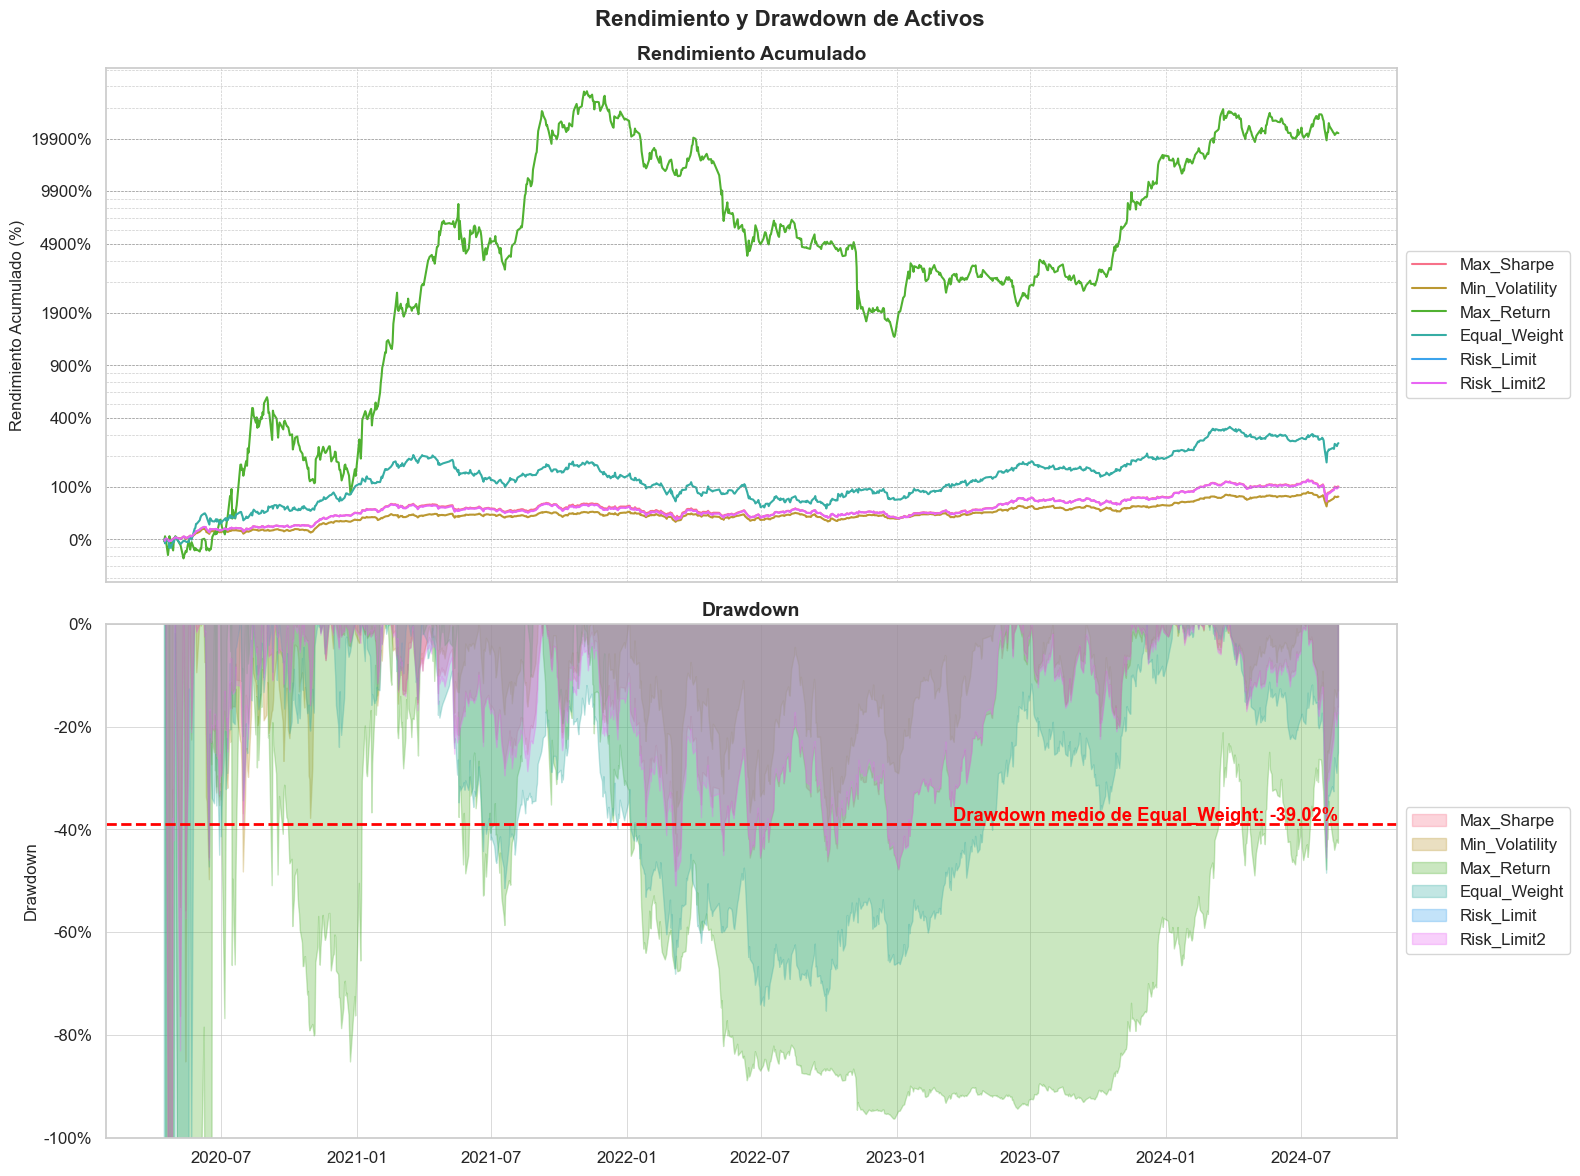

In [171]:
plot_performance_and_drawdown2(major_w_cripto_port, benchmark='Equal_Weight')

In [172]:
plot_portfolio_pies(major_w_cripto_port, risk_free=0.05, risk_limit=0.80)

ValueError: Quadratic form matrices must be symmetric/Hermitian.

In [103]:
key_metrics(major_w_cripto_port)

                           Max_Sharpe    Min_Volatility    Max_Return    Risk_Limit
-------------------------  ------------  ----------------  ------------  ------------
Start Period               2020-04-15    2020-04-15        2020-04-15    2020-04-15
End Period                 2024-08-21    2024-08-21        2024-08-21    2024-08-21
Risk-Free Rate             5.0%          5.0%              5.0%          5.0%
Time in Market             100.0%        100.0%            100.0%        100.0%

Cumulative Return          101.22%       76.16%            21,612.83%    179.57%
CAGR﹪                     11.73%        9.4%              134.74%       17.71%

Sharpe                     0.74          0.69              1.59          0.91
Prob. Sharpe Ratio         64.74%        66.38%            96.05%        71.68%
Smart Sharpe               0.72          0.67              1.54          0.88
Sortino                    1.06          0.99              2.77          1.29
Smart Sortino              1

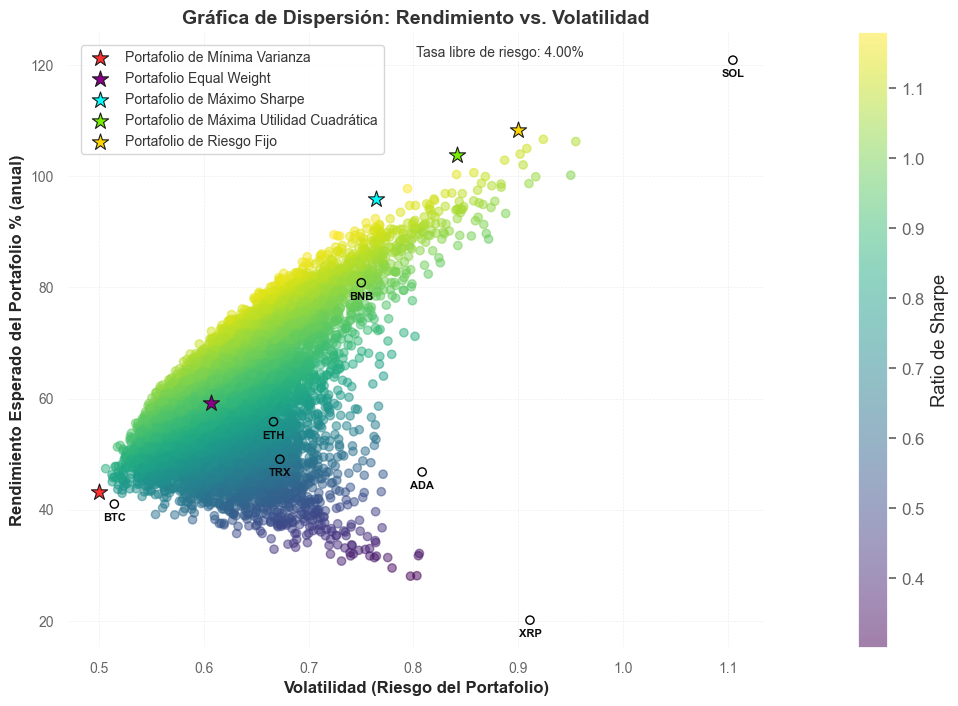

In [82]:
graficar_frontera_eficiente(cripto, iteraciones=10000, risk_free=0.04, min_weight=0.01, risk_limit=0.90)

In [114]:
metricas_etf_emergentes = key_metrics(cripto, risk_free=0.04)
print(metricas_etf_emergentes)

                           BTC         ETH         SOL         TRX         XRP
-------------------------  ----------  ----------  ----------  ----------  ----------
Start Period               2020-04-11  2020-04-11  2020-04-11  2020-04-11  2020-04-11
End Period                 2024-08-20  2024-08-20  2024-08-20  2024-08-20  2024-08-20
Risk-Free Rate             4.0%        4.0%        4.0%        4.0%        4.0%
Time in Market             100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return          764.93%     1,539.70%   15,005.86%  1,152.30%   220.76%
CAGR﹪                     40.71%      55.7%       121.28%     49.2%       20.26%

Sharpe                     0.84        0.94        1.23        0.87        0.59
Prob. Sharpe Ratio         76.4%       81.93%      94.66%      77.29%      49.49%
Smart Sharpe               0.82        0.91        1.19        0.84        0.57
Sortino                    1.26        1.41        1.99        1.33        1.0
Smart Sortino 